In [128]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np 

import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
import umap
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from amlvae.models.VAE import VAE 
from amlvae.models.VQVAE import VQVAE 
from amlvae.models.pVAE import pVAE 
from amlvae.models.cXVAE import cXVAE 
from amlvae.train.Trainer import Trainer
from amlvae.data.ExprProcessor import ExprProcessor
from amlvae.data.MutProcessor import MutProcessor
from amlvae.data.ClinProcessor import ClinProcessor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# auto reimport 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
expr_long = pd.read_csv('../../../aml_train.csv')
clin = pd.read_csv('../../../beataml_clinical_for_inputs.csv')
mut_train = pd.read_csv('~/aml_train.csv').merge(clin[['gdc_id', 'dbgap_dnaseq_sample']].drop_duplicates(), on='dbgap_dnaseq_sample').drop(['dbgap_dnaseq_sample'], axis=1).dropna().set_index('gdc_id')


In [158]:
EP = ExprProcessor(expr_long, target='fpkm_uq_unstranded', norm='zscore_log2', top_genes=1000)
X, x_ids = EP.get_data()

In [227]:
MP = MutProcessor(mut_train.dropna(), top_genes=250)
Y, y_ids = MP.get_data()

In [228]:
CP = ClinProcessor(clin, targets=['consensus_sex', 'specimenType', 'reportedRace'])

xC = CP.get_data(ids=x_ids, id_type='gdc_id')
yC = CP.get_data(ids=y_ids, id_type='gdc_id')

In [229]:
print('# expr obs:', len(x_ids))
print('# mut obs:', len(y_ids))

# expr obs: 511
# mut obs: 481


In [230]:
def exprEval(x, xhat): 

    return {'MSE': F.mse_loss(xhat, x.view(-1, x.size(1)), reduction='mean'),
            'r': np.mean([np.corrcoef(x[:, i].detach().cpu().numpy(), xhat[:,i].detach().cpu().numpy()) for i in range(xhat.size(1))]),
            'r2': r2_score(x.detach().cpu().numpy(), xhat.detach().cpu().numpy(), multioutput='uniform_average')}

def mutEval(x, xhat): 
    xhat = xhat.sigmoid()
    #xhat = torch.tensor(xhat).sigmoid().numpy() 
    return {'MSE': F.mse_loss(xhat, x.view(-1, x.size(1)), reduction='mean'),
            'r': np.mean([np.corrcoef(x[:, i].detach().cpu().numpy(), xhat[:,i].detach().cpu().numpy()) for i in range(xhat.size(1))]),
            'r2': r2_score(x.detach().cpu().numpy(), xhat.detach().cpu().numpy(), multioutput='uniform_average')}

In [231]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
xC = torch.tensor(xC, dtype=torch.float32)
yC = torch.tensor(yC, dtype=torch.float32)

/tmp/ipykernel_21062/1111217060.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


In [236]:
model = cXVAE(input_dim_dict = {'expr': X.size(1), 'mut':Y.size(1)}, 
              loss_dict = {'expr': torch.nn.MSELoss(), 'mut': torch.nn.BCEWithLogitsLoss()}, 
              eval_dict={'expr':exprEval, 'mut':mutEval},
              cond_dim=xC.size(1),
              hidden_dims=[512, 256], 
              latent_dim=124, 
              norm='layer', 
              nonlin='elu') 

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [237]:
overlapping_ids = list(np.sort(list(set(x_ids.tolist()).intersection(y_ids.tolist())))) 
print('# overlapping ids:', len(overlapping_ids))
y_idxs = np.array([np.where(y_ids == i)[0][0] for i in overlapping_ids])
x_idxs = np.array([np.where(x_ids == i)[0][0] for i in overlapping_ids])

# overlapping ids: 481


In [247]:
for epoch in range(100): 

    model.train()
    optim.zero_grad()
    out1 = model(X, xC, key='expr')
    out2 = model(Y, yC, key='mut')
    loss1 = model.loss(x=X, **out1)
    loss2 = model.loss(x=Y, **out2)

    z1 = out1['mu'][x_idxs]
    z2 = out2['mu'][y_idxs]
    #loss3 = torch.nn.functional.mse_loss(z1, z2, reduction='mean')
    # use cosine similarity instead
    loss3 = 1 - torch.nn.functional.cosine_similarity(z1, z2, dim=1).mean()
    loss = loss1 + loss2 + 10*loss3
    loss.backward()
    optim.step()

    expr_dict = model.eval_(x=X, xhat=out1['xhat'], key='expr')
    #mut_dict = model.eval_(x=Y, xhat=out2['xhat'], key='mut')
    mut_dict = {'r2': -1}

    print(f'epoch {epoch} loss: {loss.item():.3f} || expr loss: {loss1.item():.3f} expr_r2: {expr_dict['r2']:.3f} || mut loss: {loss2.item():.3f}  mut r2: {mut_dict['r2']:.3f} || alignment loss: {loss3:.3f}', end='\r')


KeyboardInterrupt: 

In [239]:
expr_dict

{'MSE': tensor(0.9547, grad_fn=<MseLossBackward0>),
 'r': np.float64(0.5882647710269941),
 'r2': 0.04337860643863678}

In [240]:
z_expr = model.encode(X, xC, key='expr')[0]
z_mut = model.encode(Y, yC, key='mut')[0]

In [241]:
z = torch.cat([z_expr, z_mut], dim=0).detach().cpu().numpy() 

In [242]:
z

array([[-0.01038721,  0.02644226,  0.03479595, ..., -0.0118656 ,
        -0.01064232,  0.00117129],
       [-0.00444633,  0.00994206, -0.02473339, ..., -0.01700426,
         0.04193914, -0.00832854],
       [-0.03595585, -0.0297718 , -0.01013678, ...,  0.04254046,
        -0.02791854,  0.01378402],
       ...,
       [ 0.01089552, -0.00407043, -0.01887286, ...,  0.00271857,
         0.00619247, -0.00137688],
       [ 0.00933728, -0.02930692,  0.02429545, ..., -0.01917066,
        -0.00694133, -0.01555917],
       [-0.00543049,  0.00348842, -0.00861248, ...,  0.00713951,
        -0.00854862, -0.0038936 ]], dtype=float32)

In [243]:
reducer = umap.UMAP()
z_umap = reducer.fit_transform(z)

ures = pd.DataFrame(z_umap, columns=['umap1', 'umap2']).assign(encoder=['expr']*len(z_expr) + ['mut']*len(z_mut))
ures.head()

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,umap1,umap2,encoder
0,0.636562,4.621595,expr
1,-3.972092,5.636616,expr
2,-2.903824,8.292534,expr
3,-0.016080,4.865986,expr
4,-2.985631,8.454338,expr


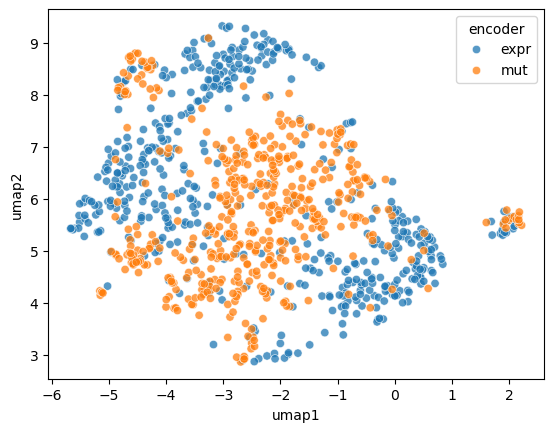

In [244]:
plt.figure() 
sbn.scatterplot(data=ures, x='umap1', y='umap2', hue='encoder', alpha=0.75)
plt.show()